## Fraud Detection with Pytorch 
### Using Content Feature

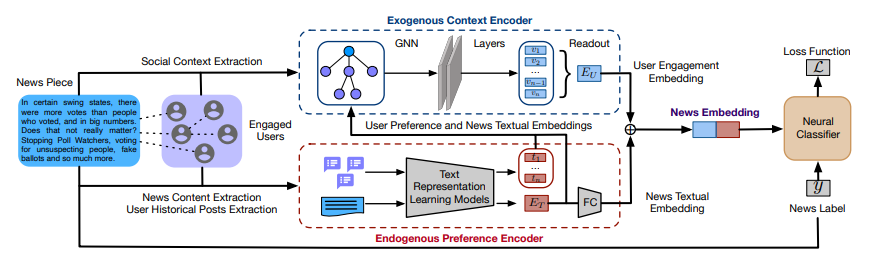

### Installation

PyTorch Geometric: https://pytorch-geometric.readthedocs.io/en/latest/

PyG (PyTorch Geometric) is a library built upon PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data.

It consists of various methods for deep learning on graphs and other irregular structures, also known as geometric deep learning, from a variety of published papers.

In [1]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

import torch_geometric

C:\Users\Kayra\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch vers:  1.13.0+cpu


### Dataset

- Contains news propagation graphs extracted from Twitter
- Source and raw data: https://github.com/KaiDMML/FakeNewsNet
- Preprocessing: https://arxiv.org/pdf/2104.12259.pdf
- feature="content" --> Spacy Word2Vec + Profile features

FakeNewsNet - gossipcop (fake + real csv):
id - news_url - title - tweet_ids

UPFD:
PyG dataset: https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/upfd.html

- It includes 2 sets of tree-structured fake & real news propagation graphs extracted from Twitter.

- For a single graph, the root node represents the source news, and leaf nodes represent Twitter users who retweeted the same root news.

- 4 different node features are encoded using different encoders.
    - profile: 10-dimensional Twitter user profile attributes.
    - spacy: 300-dimensional Twitter user historical tweets encoded by spaCy word2vec encoder.
    - bert: 768-dimensional Twitter user historical tweets encoded by bert-as-service.
    - content: 310-dimensional spacy (300-dimensional) + profile (10-dimensional).

In [2]:
from torch_geometric.datasets import UPFD
train_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Extracting .\gossipcop\raw\uc
Processing...
Done!


Train Samples:  1092
Test Samples:  3826


#### Investigating the News Propagation Graph

In [14]:
sample_id=40

print("Sample data\n", train_data[sample_id])

print("\nx values\n",train_data[sample_id].x)

print("\nEdge indices\n",train_data[sample_id].edge_index)

print("\ny value\n",train_data[sample_id].y)

Sample data
 Data(x=[5, 310], edge_index=[2, 4], y=[1])

x values
 tensor([[0.4652, 0.5628, 0.5172,  ..., 0.1986, 0.0926, 0.0784],
        [0.4508, 0.5909, 0.5090,  ..., 0.1986, 0.1111, 0.1029],
        [0.4652, 0.5628, 0.5172,  ..., 0.1986, 0.0926, 0.0784],
        [0.4508, 0.5909, 0.5090,  ..., 0.1986, 0.1111, 0.1029],
        [0.4939, 0.5066, 0.5336,  ..., 0.1986, 0.0556, 0.0294]])

Edge indices
 tensor([[0, 0, 0, 3],
        [1, 2, 3, 4]])

y value
 tensor([1])


In [16]:
# Graph Visualization

# !pip install networkx
import networkx as nx

# From PyG utils
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False,
                remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

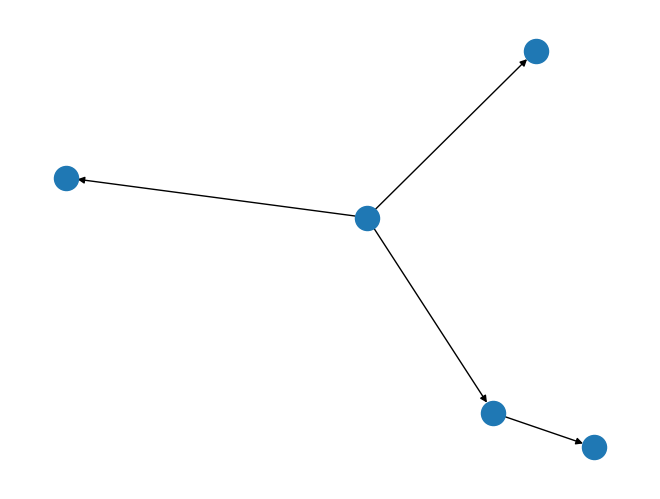

In [17]:
nx.draw(to_networkx(train_data[sample_id]))

#### Node features

In [18]:
print(train_data[sample_id].x.shape)
train_data[sample_id].x

# 5 Nodes each has 310-dimensional embeddings

torch.Size([5, 310])


tensor([[0.4652, 0.5628, 0.5172,  ..., 0.1986, 0.0926, 0.0784],
        [0.4508, 0.5909, 0.5090,  ..., 0.1986, 0.1111, 0.1029],
        [0.4652, 0.5628, 0.5172,  ..., 0.1986, 0.0926, 0.0784],
        [0.4508, 0.5909, 0.5090,  ..., 0.1986, 0.1111, 0.1029],
        [0.4939, 0.5066, 0.5336,  ..., 0.1986, 0.0556, 0.0294]])

#### Class distribution

<AxesSubplot:>

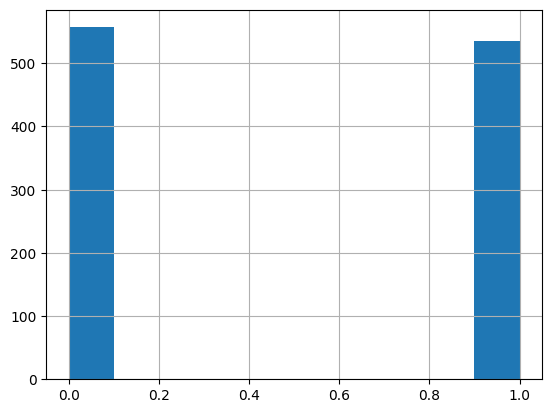

In [19]:
import pandas as pd
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

#### Data Loaders

In [25]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

### Model and Training

--> Because it is a directed graph, it will only share information from the root

GATConv: Graph attentional operator --> https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv

global_max_pool: returns batch-wise graph-level-outputs --> https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_max_pool.html#torch_geometric.nn.pool.global_max_pool

In [20]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear


class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news 
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()
        
        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

In [23]:
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [26]:
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.77 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 01 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 02 |  TrainLoss: 0.70 | TestLoss: 0.72 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 03 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.79 | TestF1: 0.83
Epoch: 04 |  TrainLoss: 0.68 | TestLoss: 0.72 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 05 |  TrainLoss: 0.71 | TestLoss: 0.73 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 06 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.02
Epoch: 07 |  TrainLoss: 0.68 | TestLoss: 0.67 | TestAcc: 0.77 | TestF1: 0.81
Epoch: 08 |  TrainLoss: 0.67 | TestLoss: 0.67 | TestAcc: 0.50 | TestF1: 0.01
Epoch: 09 |  TrainLoss: 0.66 | TestLoss: 0.65 | TestAcc: 0.73 | TestF1: 0.64
Epoch: 10 |  TrainLoss: 0.66 | TestLoss: 0.72 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 11 |  TrainLoss: 0.66 | TestLoss: 0.62 | TestAcc: 0.82 | TestF1: 0.85
Epoch: 12 |  TrainLoss: 0.62 | TestLoss: 0.61 | TestAcc: 0.84 | TestF1: 0.81

In [27]:
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().numpy()[:,0]
    df["pred"] = torch.round(pred).detach().numpy()[:,0]
    df["true"] = data.y.numpy()
    print(df.head(10))
    break

   pred_logit  pred  true
0    0.695083   1.0     1
1    0.518091   1.0     1
2    0.222078   0.0     0
3    0.523404   1.0     1
4    0.059458   0.0     0
5    0.201323   0.0     0
6    0.146157   0.0     0
7    0.808935   1.0     1
8    0.063947   0.0     0
9    0.138881   0.0     0
